In [1]:
import torch

from loguru import logger
import matplotlib.pyplot as plt

from pettingzoo.atari import combat_tank_v2
from pettingzoo.atari import space_war_v2

from src.utils import (
    
    save_episode_as_gif,
    loss_fn
)
from src.agent import Agent, load
from src.policy_zero import PolicyZero
# from src.viz import save_multi_agent_episode
from IPython.display import Image

plt.ion()

import warnings
warnings.filterwarnings("ignore")
torch.set_default_dtype(torch.float32)
SEED = 42

2024-12-04 14:50:30.485 | INFO     | src.utils:device:66 - Using cuda device.


In [2]:

# instantiate the environment
env = space_war_v2.env(render_mode="rgb_array")
# env = combat_tank_v2.env(render_mode="rgb_array", has_maze=False)
env.reset(seed=SEED)

# get the state and action dimensions
observation = env.last()[0]  # Get initial observation
H, W, C = observation.shape # (height, width, channels)
action_dim = env.action_space("first_0").n

# num_actions = environment.action_space.n
# state_dimension = environment.observation_space.shape[0]
print(f"Input channels: {C}\nAction space: {action_dim}")

Input channels: 3
Action space: 18


In [3]:



################################## Hyper-parameters Tuning ##################################
state_dimension: int = 64
num_actions: int = action_dim
EPOCHS: int = 80
HIDDEN_DIMENSION: int = 128
LEARNING_RATE: float = 3e-2
DISCOUNT_FACTOR: float = .97
EPISODES: int = 3_000
gamma = DISCOUNT_FACTOR

#############################################################################################

player_one = Agent('first_0', state_dimension, num_actions, HIDDEN_DIMENSION, LEARNING_RATE, obs_dim=(C, H, W), gamma=DISCOUNT_FACTOR)
player_two = Agent('second_0', state_dimension, num_actions, HIDDEN_DIMENSION, 2*LEARNING_RATE, obs_dim=(C, H, W), gamma=DISCOUNT_FACTOR)

# player_one = load('space_reinforce/first_0.pt')
# player_two = load('space_reinforce/second_0.pt')
player_two.policy = PolicyZero(state_dimension, num_actions, HIDDEN_DIMENSION, C, H, W)
# player_two.policy.vision_enc.load_state_dict(player_one.policy.vision_enc.state_dict())

all_players = [player_one, player_two]
agents_map = dict(zip(env.agents, all_players))

agent_scores =  {k: 0 for k in env.agents}


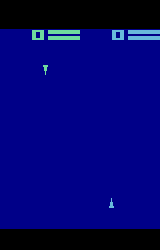

In [6]:
gif_path = save_episode_as_gif(env, agents_map, save_path=f"epoch_{0}.gif", fps=60)    
Image(open(gif_path,'rb').read())

In [29]:
start = 0
EPOCHS: int = 6400

In [ ]:

for epoch in range(start, start + EPOCHS):
    # run one episode 
    env.reset()
    for step, agent_name in enumerate(env.agent_iter()):
        
        agent = agents_map[agent_name]
        win = agent.take_action(env)

        if win or step > 2*EPISODES:
            agent_scores[agent_name] += int(win)
            winner = agent_name
            break
    
    win_values = list(agent_scores.values())
    logger.info(f'Epoch: {epoch+1:4}/{EPOCHS} \t| Winner: {winner:10} \t| Steps: {step} | Win ratio: {win_values[0]/(win_values[1]+1e-8):.3f}')
    for player in all_players:
        if player.name == "second_0":
            continue
        loss, reward = player.optimize(1)
        
        logger.debug(f"Player: {player.name} \t| Cache Size: {len(player.cache)} \t| Loss: {loss:.5f} \t| Reward: {reward :.3f}")
        player.clear_cache()
        player.save("space_reinforce")
    
    if (epoch+1) % 10 == 0:
        save_episode_as_gif(env, agents_map, save_path=f"episodes_space_reinforce/epoch_{epoch+1}.gif", fps=60)    

2024-11-28 02:18:30.635 | INFO     | __main__:<module>:15 - Epoch:    1/6400 	| Winner: first_0    	| Steps: 838 | Win ratio: 0.815
2024-11-28 02:18:31.401 | DEBUG    | __main__:<module>:21 - Player: first_0 	| Cache Size: 1028 	| Loss: 0.00000 	| Reward: 0.000
2024-11-28 02:18:32.221 | DEBUG    | __main__:<module>:21 - Player: second_0 	| Cache Size: 1026 	| Loss: 0.00000 	| Reward: 0.000
2024-11-28 02:18:36.265 | INFO     | __main__:<module>:15 - Epoch:    2/6400 	| Winner: first_0    	| Steps: 2476 | Win ratio: 0.852
2024-11-28 02:18:37.204 | DEBUG    | __main__:<module>:21 - Player: first_0 	| Cache Size: 1239 	| Loss: 0.00000 	| Reward: 0.000
2024-11-28 02:18:38.195 | DEBUG    | __main__:<module>:21 - Player: second_0 	| Cache Size: 1238 	| Loss: 0.00000 	| Reward: 0.000
2024-11-28 02:18:44.552 | INFO     | __main__:<module>:15 - Epoch:    3/6400 	| Winner: second_0   	| Steps: 3915 | Win ratio: 0.821
2024-11-28 02:18:46.022 | DEBUG    | __main__:<module>:21 - Player: first_0 	| C

KeyboardInterrupt: 

In [31]:
agent_scores

{'first_0': 3242, 'second_0': 1576}

In [32]:
len(player_one.cache)

464

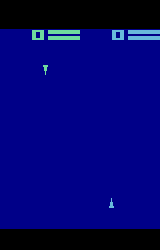

In [33]:
gif_path = save_episode_as_gif(env, agents_map, save_path=f"epoch_{epoch+1}.gif", fps=60)    
Image(open(gif_path,'rb').read())